In [1]:
import os
from glob import glob 
import time
import random
from datetime import datetime

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

random_seed(42)

In [23]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, data_path, ids, targets=None, transform=None):
        self.ids = ids
        self.targets = targets
        self.data_path = data_path
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ID = self.ids[idx]
        image_path = os.path.join(self.data_path, ID)
        img = np.array(Image.open(image_path))
        if self.transform:
            img = self.transform(image=img)['image']
        if self.targets is not None:
            return img, self.targets[idx]
        else:
            return img

In [4]:
def train_per_epoch(model, train_loader, loss_fn, optimizer):
    preds_list = []
    targets_list = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        current_loss = 0.0
        current_correct = 0.0

        # Forward 
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, labels)

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds_list.extend(preds.detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        current_loss += loss.item()

        if batch_idx % log_interval == 0:
            train_loss = current_loss / log_interval
            train_acc = accuracy_score(targets_list, preds_list)
            train_f1 = f1_score(targets_list, preds_list, average='macro')

            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}, Train Acc: {:.4f}, Train F1 Score: {:.4f}".format(
                epoch, 
                batch_idx * len(images), 
                len(train_loader) * len(images), 
                100 * batch_idx / len(train_loader), 
                train_loss, 
                train_acc,
                train_f1))
           
    return current_loss / len(train_loader), accuracy_score(targets_list, preds_list), f1_score(targets_list, preds_list, average='macro')
    
def validation(model, val_loader, loss_fn):
    val_preds_list = []
    val_targets_list = []
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0.0
        model.eval()

        for val_idx, (val_images, val_labels) in enumerate(val_loader):
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)

            val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
            
            val_preds_list.extend(val_preds.detach().cpu().numpy())
            val_targets_list.extend(val_labels.detach().cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = accuracy_score(val_targets_list, val_preds_list)
        val_epoch_f1 = f1_score(val_targets_list, val_preds_list, average='macro')

        print("Validation dataset: Val Loss: {:.6f}, Val Acc: {:.4f}, Val F1 Score: {:.4f}".format(val_epoch_loss, val_epoch_acc, val_epoch_f1))
    return val_epoch_loss, val_epoch_acc, val_epoch_f1

In [69]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
train_data_path = '../data/train/'
test_data_path = '../data/test/'

image_paths = glob(os.path.join(data_path, '*.jpg'))

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 224
LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 64
num_workers = 0
log_interval = 100

In [88]:
df = pd.read_csv('../data/add_transformed_train.csv')
sample_submission_df = pd.read_csv("../data/sample_submission.csv")

In [7]:
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
print(len(df_train), len(df_val))

28192 7048


In [90]:
train_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
valid_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [91]:
# Dataset 정의
train_dataset = ImageDataset(
    train_data_path,
    df_train['ID'].values,
    df_train['target'].values,
    transform=trn_transform
)
valid_dataset = ImageDataset(
    train_data_path,
    df_val['ID'].values,
    df_val['target'].values,
    transform=tst_transform
)
test_dataset = ImageDataset(
    test_data_path,
    sample_submission_df['ID'].values,
    transform=test_transform
)
print(len(train_dataset), len(valid_dataset), len(test_dataset))

28192 7048 3140


In [92]:
# DataLoader 정의
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [31]:
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [32]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

In [33]:
save_point = 0
path = os.path.join(model_path, 'model.ckpt')

train_result = []
val_result = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = train_per_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc, val_f1 = validation(model, valid_loader, loss_fn)
    train_result.append([train_loss, train_acc, train_f1])
    val_result.append([val_loss, val_acc, val_f1])

    if val_f1 > save_point:
        save_point = val_f1
        save_dir = os.path.dirname(path)
        torch.save(model, os.path.join(save_dir, f'val_f1-{val_f1}-{path.split("/")[-1]}'))
        print('Saved Model!!!')

Train Epoch: 1 [0/28224 (0%)]	Train Loss: 0.028177, Train Acc: 0.0469, Train F1 Score: 0.0229
Train Epoch: 1 [6400/28224 (23%)]	Train Loss: 0.005879, Train Acc: 0.6091, Train F1 Score: 0.6017
Train Epoch: 1 [12800/28224 (45%)]	Train Loss: 0.002975, Train Acc: 0.7338, Train F1 Score: 0.7262
Train Epoch: 1 [19200/28224 (68%)]	Train Loss: 0.002731, Train Acc: 0.7850, Train F1 Score: 0.7799
Train Epoch: 1 [25600/28224 (91%)]	Train Loss: 0.001377, Train Acc: 0.8178, Train F1 Score: 0.8141
Validation dataset: Val Loss: 0.003156, Val Acc: 0.9272, Val F1 Score: 0.9246
Saved Model!!!
Train Epoch: 2 [0/28224 (0%)]	Train Loss: 0.002229, Train Acc: 0.9219, Train F1 Score: 0.9034
Train Epoch: 2 [6400/28224 (23%)]	Train Loss: 0.004790, Train Acc: 0.7840, Train F1 Score: 0.7811
Train Epoch: 2 [12800/28224 (45%)]	Train Loss: 0.002050, Train Acc: 0.8394, Train F1 Score: 0.8373
Train Epoch: 2 [19200/28224 (68%)]	Train Loss: 0.001830, Train Acc: 0.8622, Train F1 Score: 0.8599
Train Epoch: 2 [25600/28224 

In [94]:
best_model = torch.load('../code/runs/2024-02-06T05:35:33-resnet34/models/val_f1-0.9704536673579104-model.ckpt')

In [47]:
val_preds_list = []
val_targets_list = []

with torch.no_grad():
    val_loss = 0.0
    val_correct = 0.0
    best_model.eval()

    for val_idx, (val_images, val_labels) in enumerate(valid_loader):
        val_images, val_labels = val_images.to(device), val_labels.to(device)

        val_outputs = best_model(val_images)
        _, val_preds = torch.max(val_outputs, 1)

        val_loss += loss_fn(val_outputs, val_labels) / val_outputs.shape[0]
        
        val_preds_list.extend(val_preds.detach().cpu().numpy())
        val_targets_list.extend(val_labels.detach().cpu().numpy())

In [51]:
accuracy_score(val_targets_list, val_preds_list)

0.9709137343927355

In [53]:
df_val[df_val['target'] == df_val['pred']].target.count()

6843

In [114]:
df_val[df_val['target'] != df_val['pred']].target.count()

205

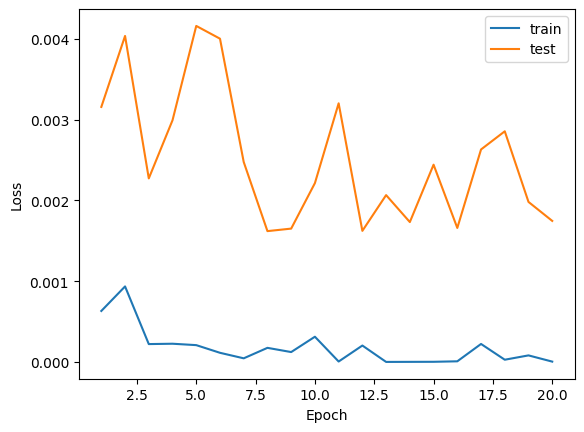

In [65]:
# plt.style.use('seaborn')
plt.plot([i for i in range(1, EPOCHS + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, EPOCHS + 1)], [i[0].detach().cpu().numpy() for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"])
plt.show()

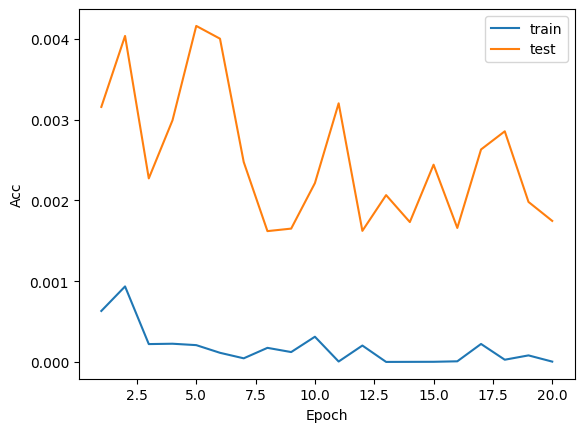

In [66]:
plt.plot([i for i in range(1, EPOCHS + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, EPOCHS + 1)], [i[0].detach().cpu().numpy() for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(["train", "test"])
plt.show()

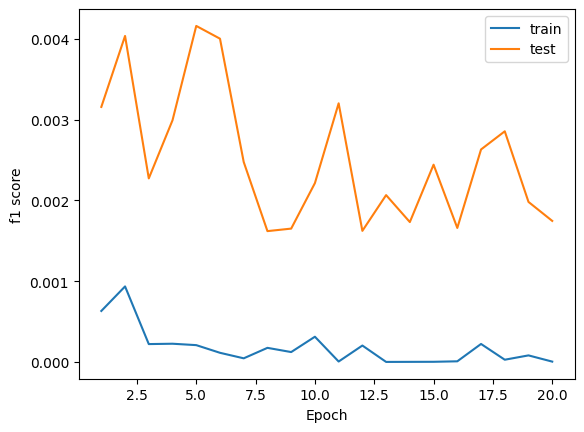

In [67]:
plt.plot([i for i in range(1, EPOCHS + 1)], [i[0] for i in train_result])
plt.plot([i for i in range(1, EPOCHS + 1)], [i[0].detach().cpu().numpy() for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("f1 score")
plt.legend(["train", "test"])
plt.show()

In [95]:
preds_list = []

best_model.eval()
for image in tqdm(test_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = best_model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


In [ ]:
assert (sample_submission_df['ID'] == test_dataset.ids).all()

In [98]:
pred_df = pd.DataFrame(test_dataset.ids, columns=['ID'])
pred_df['target'] = preds_list

In [101]:
pred_df.to_csv("pred.csv", index=False)